# Определение перспективного тарифа для мобильного оператора

Вы аналитик компании «Мегалайн» — федерального оператора сотовой связи. Клиентам предлагают два тарифных плана: «Смарт» и «Ультра». Чтобы скорректировать рекламный бюджет, коммерческий департамент хочет понять, какой тариф приносит больше денег

Вам предстоит сделать предварительный анализ тарифов на небольшой выборке клиентов. В вашем распоряжении данные 500 пользователей «Мегалайна»: кто они, откуда, каким тарифом пользуются, сколько звонков и сообщений каждый отправил за 2018 год. Нужно проанализировать поведение клиентов и сделать вывод — какой тариф лучше.

## Шаг 1. Изучаем общую информацию

In [1]:
import pandas as pd
from scipy import stats as st
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
calls = pd.read_csv('/datasets/calls.csv')

In [3]:
internet = pd.read_csv('/datasets/internet.csv')

In [4]:
messages = pd.read_csv('/datasets/messages.csv')

In [5]:
tariffs = pd.read_csv('/datasets/tariffs.csv')

In [6]:
users = pd.read_csv('/datasets/users.csv')

In [7]:
calls.head()

,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.00,1000
1,1000_1,2018-08-17,0.00,1000
2,1000_2,2018-06-11,2.85,1000
3,1000_3,2018-09-21,13.80,1000
4,1000_4,2018-12-15,5.18,1000


In [8]:
internet.head()

,Unnamed: 0,id,mb_used,session_date,user_id
0,0,1000_0,112.95,2018-11-25,1000
1,1,1000_1,1052.81,2018-09-07,1000
2,2,1000_2,1197.26,2018-06-25,1000
3,3,1000_3,550.27,2018-08-22,1000
4,4,1000_4,302.56,2018-09-24,1000


In [9]:
messages.head()

,id,message_date,user_id
0,1000_0,2018-06-27,1000
1,1000_1,2018-10-08,1000
2,1000_2,2018-08-04,1000
3,1000_3,2018-06-16,1000
4,1000_4,2018-12-05,1000


In [85]:
tariffs.rename(columns={'tariff_name': 'tariff'}, inplace=True) #переименуем колонку, чтобы удобнее merge делать в будущем
tariffs

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff,gb_per_month_included
0,50,15360,500,550,200,3,3,smart,15.0
1,1000,30720,3000,1950,150,1,1,ultra,30.0


In [84]:
tariffs['gb_per_month_included'] = tariffs['mb_per_month_included'] / 1024 #добавим ГБ для удобства

In [12]:
tariffs

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff,gb_per_month_included
0,50,15360,500,550,200,3,3,smart,15.0
1,1000,30720,3000,1950,150,1,1,ultra,30.0


In [13]:
users.head()

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,NaN,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,NaN,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra


In [14]:
users.info() #churn_date и reg_date привести к daytime

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
user_id       500 non-null int64
age           500 non-null int64
churn_date    38 non-null object
city          500 non-null object
first_name    500 non-null object
last_name     500 non-null object
reg_date      500 non-null object
tariff        500 non-null object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


In [15]:
calls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
id           202607 non-null object
call_date    202607 non-null object
duration     202607 non-null float64
user_id      202607 non-null int64
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB


In [16]:
internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 5 columns):
Unnamed: 0      149396 non-null int64
id              149396 non-null object
mb_used         149396 non-null float64
session_date    149396 non-null object
user_id         149396 non-null int64
dtypes: float64(1), int64(2), object(2)
memory usage: 5.7+ MB


In [17]:
messages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
id              123036 non-null object
message_date    123036 non-null object
user_id         123036 non-null int64
dtypes: int64(1), object(2)
memory usage: 2.8+ MB


In [18]:
tariffs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 9 columns):
messages_included        2 non-null int64
mb_per_month_included    2 non-null int64
minutes_included         2 non-null int64
rub_monthly_fee          2 non-null int64
rub_per_gb               2 non-null int64
rub_per_message          2 non-null int64
rub_per_minute           2 non-null int64
tariff                   2 non-null object
gb_per_month_included    2 non-null float64
dtypes: float64(1), int64(7), object(1)
memory usage: 272.0+ bytes


## Шаг 2. Подготавливаем данные

Приведите данные к нужным типам;

Найдите и исправьте ошибки в данных, если они есть.
Поясните, какие ошибки вы нашли и как их исправили. 

В данных вы найдёте звонки с нулевой продолжительностью. Это не ошибка: нулями обозначены пропущенные звонки, поэтому их не нужно удалять.

Посчитайте для каждого пользователя:

количество сделанных звонков и израсходованных минут разговора по месяцам;

количество отправленных сообщений по месяцам;

объем израсходованного интернет-трафика по месяцам;

помесячную выручку с каждого пользователя (вычтите бесплатный лимит из суммарного количества звонков, сообщений и интернет-трафика; 

остаток умножьте на значение из тарифного плана; 
прибавьте абонентскую плату, соответствующую тарифному плану).

In [19]:
internet.columns

Index(['Unnamed: 0', 'id', 'mb_used', 'session_date', 'user_id'], dtype='object')

In [20]:
internet = internet.drop('Unnamed: 0', 1)

In [21]:
users.head()

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,NaN,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,NaN,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra


Поменяем тип данных на daytime

In [22]:
users.churn_date = pd.to_datetime(users.churn_date, format='%Y-%m-%d')

In [23]:
users.reg_date = pd.to_datetime(users.reg_date, format='%Y-%m-%d')

In [24]:
calls.call_date  = pd.to_datetime(calls.call_date, format='%Y-%m-%d')

In [25]:
internet.session_date  = pd.to_datetime(internet.session_date , format='%Y-%m-%d')

In [26]:
messages.message_date = pd.to_datetime(messages.message_date , format='%Y-%m-%d')

Создадим столбцы с месяцами, чтобы показать когда произошло событие

In [27]:
calls['month'] = calls["call_date"].dt.month

In [28]:
messages['month'] = messages["message_date"].dt.month

In [29]:
internet['month'] = internet['session_date'].dt.month

<b/>количество сделанных звонков и израсходованных минут разговора по месяцам<b/>

In [70]:
calls_sum = calls.pivot_table(index=['user_id', 'month'], values=['duration'],aggfunc=[np.sum]).apply(np.ceil).astype('int')
#округялем звонки в большую сторону как делает оператор
calls_sum.columns = ['calls_sum'] 

calls_sum.head(5)

calls_sum
user_id month           
1000    5            151
        6            159
        7            319
        8            390
        9            441

In [69]:
calls_count = calls.pivot_table(index=['user_id', 'month'], values=['id'],aggfunc='count')
calls_count.columns = ['calls_count']
calls_count.head(5)

calls_count
user_id month             
1000    5               22
        6               43
        7               47
        8               52
        9               58

<b/>количество отправленных сообщений по месяцам<b/>

In [68]:
messages_count = messages.pivot_table(index=['user_id', 'month'], values=['id'],aggfunc='count')
messages_count.columns = ['messages_count']
messages_count.head(5)

messages_count
user_id month                
1000    5                  22
        6                  60
        7                  75
        8                  81
        9                  57

<b/>объем израсходованного интернет-трафика по месяцам<b/>

In [67]:
internet_volume = internet.pivot_table(index=['user_id', 'month'], values=['mb_used'],aggfunc=[np.sum])
internet_volume.columns = ['internet_sum']
internet_volume.head(5)

internet_sum
user_id month              
1000    5           2253.49
        6          23233.77
        7          14003.64
        8          14055.93
        9          14568.91

In [71]:
internet_volume['internet_sum_gb'] = (internet_volume['internet_sum']/1024).apply(np.ceil).astype('int')
#переводим в ГБ и округялем значения в большую сторону, как описано в задании
internet_volume.head(5)

internet_sum  internet_sum_gb
user_id month                               
1000    5           2253.49                3
        6          23233.77               23
        7          14003.64               14
        8          14055.93               14
        9          14568.91               15

помесячную выручку с каждого пользователя (вычтите бесплатный лимит из суммарного количества звонков, сообщений и интернет-трафика; остаток умножьте на значение из тарифного плана; прибавьте абонентскую плату, соответствующую тарифному плану)

In [72]:
data1 = pd.merge(calls_sum,calls_count, on=['user_id','month']) #делаем итеративно соединение 4 таблиц, т.к.кучей ядро падает
data1.head(5)

calls_sum  calls_count
user_id month                        
1000    5            151           22
        6            159           43
        7            319           47
        8            390           52
        9            441           58

In [73]:
data2 = pd.merge(data1, messages_count, on=['user_id','month']) #делаем итеративно соединение 4 таблиц, т.к.кучей ядро падает
data2.head(5)

calls_sum  calls_count  messages_count
user_id month                                        
1000    5            151           22              22
        6            159           43              60
        7            319           47              75
        8            390           52              81
        9            441           58              57

In [74]:
data3 = pd.merge(data2, internet_volume, on=['user_id','month']) #делаем итеративно соединение 4 таблиц, т.к.кучей ядро падает
data3 = data3.drop('internet_sum', 1)
data3.head(5)

calls_sum  calls_count  messages_count  internet_sum_gb
user_id month                                                         
1000    5            151           22              22                3
        6            159           43              60               23
        7            319           47              75               14
        8            390           52              81               14
        9            441           58              57               15

In [75]:
data4 = data3.reset_index() #убираем мультииндекс
data4.head(5)

,user_id,month,calls_sum,calls_count,messages_count,internet_sum_gb
0,1000,5,151,22,22,3
1,1000,6,159,43,60,23
2,1000,7,319,47,75,14
3,1000,8,390,52,81,14
4,1000,9,441,58,57,15


In [39]:
data_user_profit = pd.merge(data4, users, on='user_id') 
data_user_profit.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2667 entries, 0 to 2666
Data columns (total 13 columns):
user_id            2667 non-null int64
month              2667 non-null int64
calls_sum          2667 non-null int64
calls_count        2667 non-null int64
messages_count     2667 non-null int64
internet_sum_gb    2667 non-null int64
age                2667 non-null int64
churn_date         139 non-null datetime64[ns]
city               2667 non-null object
first_name         2667 non-null object
last_name          2667 non-null object
reg_date           2667 non-null datetime64[ns]
tariff             2667 non-null object
dtypes: datetime64[ns](2), int64(7), object(4)
memory usage: 291.7+ KB


In [40]:
data_user_profit.columns

Index(['user_id', 'month', 'calls_sum', 'calls_count', 'messages_count',
       'internet_sum_gb', 'age', 'churn_date', 'city', 'first_name',
       'last_name', 'reg_date', 'tariff'],
      dtype='object')

In [41]:
data_user_profit = data_user_profit.drop(['calls_count','age', 'churn_date', 'first_name',
       'last_name', 'reg_date'], 1)

In [42]:
#data_user_profit.query('tariff == "smart" & calls_sum > 500')

помесячную выручку с каждого пользователя (вычтите бесплатный лимит из суммарного количества звонков, сообщений и интернет-трафика; остаток умножьте на значение из тарифного плана; прибавьте абонентскую плату, соответствующую тарифному плану).

In [43]:
data_profit_tariff = pd.merge(data_user_profit, tariffs, on='tariff')

In [44]:
data_profit_tariff.drop('mb_per_month_included', 1, inplace=True)

In [45]:
data_profit_tariff.rename(columns={'messages_count':'mes_count', 'internet_sum_gb':'int_sum_gb',
        'messages_included':'mess_incl', 'minutes_included':'min_incl', 'gb_per_month_included':'int_gb_incl', 'rub_per_message':'rub_per_mess', 'rub_per_minute':'rub_per_min'
       }, inplace=True) #привести к виду, чтобы умещалось в ширину окна

In [46]:
data_profit_tariff['int_gb_incl'] = data_profit_tariff['int_gb_incl'].astype('int')
data_profit_tariff.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2667 entries, 0 to 2666
Data columns (total 14 columns):
user_id            2667 non-null int64
month              2667 non-null int64
calls_sum          2667 non-null int64
mes_count          2667 non-null int64
int_sum_gb         2667 non-null int64
city               2667 non-null object
tariff             2667 non-null object
mess_incl          2667 non-null int64
min_incl           2667 non-null int64
rub_monthly_fee    2667 non-null int64
rub_per_gb         2667 non-null int64
rub_per_mess       2667 non-null int64
rub_per_min        2667 non-null int64
int_gb_incl        2667 non-null int64
dtypes: int64(12), object(2)
memory usage: 312.5+ KB


In [47]:
data_profit_tariff.head(5)

,user_id,month,calls_sum,mes_count,int_sum_gb,city,tariff,mess_incl,min_incl,rub_monthly_fee,rub_per_gb,rub_per_mess,rub_per_min,int_gb_incl
0,1000,5,151,22,3,Краснодар,ultra,1000,3000,1950,150,1,1,30
1,1000,6,159,60,23,Краснодар,ultra,1000,3000,1950,150,1,1,30
2,1000,7,319,75,14,Краснодар,ultra,1000,3000,1950,150,1,1,30
3,1000,8,390,81,14,Краснодар,ultra,1000,3000,1950,150,1,1,30
4,1000,9,441,57,15,Краснодар,ultra,1000,3000,1950,150,1,1,30


In [48]:
#создадим функцию, которая будет считать прибыль для каждой строчки - месяца
#и перебираем все условия, чтобы не было 0 и отрицательных чисел

def profit_calc(row):
    if row['calls_sum'] < row['min_incl'] and row['mes_count'] < row ['mess_incl'] and row['int_sum_gb'] < row['int_gb_incl']:
        return row['rub_monthly_fee']
    elif row['calls_sum'] > row['min_incl'] and row['mes_count'] > row ['mess_incl'] and row['int_sum_gb'] > row['int_gb_incl']:
        return row['rub_monthly_fee']\
               + (row['calls_sum'] - row['min_incl']) * row['rub_per_min']\
               + (row['mes_count'] - row['mess_incl']) * row['rub_per_mess']\
               + (row['int_sum_gb'] - row['int_gb_incl']) * row['rub_per_gb']
    elif row['calls_sum'] > row['min_incl'] and row['mes_count'] > row ['mess_incl']:
        return row['rub_monthly_fee']\
               + (row['calls_sum'] - row['min_incl']) * row['rub_per_min']\
               + (row['mes_count'] - row['mess_incl']) * row['rub_per_mess']
    elif row['calls_sum'] > row['min_incl'] and row['int_sum_gb'] > row['int_gb_incl']:
        return row['rub_monthly_fee']\
               + (row['calls_sum'] - row['min_incl']) * row['rub_per_min']\
               + (row['int_sum_gb'] - row['int_gb_incl']) * row['rub_per_gb']
    elif row['calls_sum'] >= row['min_incl']:
        return row['rub_monthly_fee']\
               + (row['calls_sum'] - row['min_incl']) * row['rub_per_min']
    elif row['mes_count'] > row ['mess_incl'] and row['int_sum_gb'] > row['int_gb_incl']:
        return row['rub_monthly_fee']\
               + (row['mes_count'] - row['mess_incl']) * row['rub_per_mess']\
               + (row['int_sum_gb'] - row['int_gb_incl']) * row['rub_per_gb']
    elif row['mes_count'] >= row ['mess_incl']:
        return row['rub_monthly_fee']\
               + (row['mes_count'] - row['mess_incl']) * row['rub_per_mess']
    elif row['int_sum_gb'] >= row['int_gb_incl']:
        return row['rub_monthly_fee']\
               + (row['int_sum_gb'] - row['int_gb_incl']) * row['rub_per_gb']   

In [49]:
#data_profit_tariff[pd.isnull(data_profit_tariff['profit'])] проверял какие данные с NaN

In [50]:
data_profit_tariff['profit'] =  data_profit_tariff.apply(profit_calc, axis=1) #применяем

In [51]:
data_profit_tariff.head()

,user_id,month,calls_sum,mes_count,int_sum_gb,city,tariff,mess_incl,min_incl,rub_monthly_fee,rub_per_gb,rub_per_mess,rub_per_min,int_gb_incl,profit
0,1000,5,151,22,3,Краснодар,ultra,1000,3000,1950,150,1,1,30,1950
1,1000,6,159,60,23,Краснодар,ultra,1000,3000,1950,150,1,1,30,1950
2,1000,7,319,75,14,Краснодар,ultra,1000,3000,1950,150,1,1,30,1950
3,1000,8,390,81,14,Краснодар,ultra,1000,3000,1950,150,1,1,30,1950
4,1000,9,441,57,15,Краснодар,ultra,1000,3000,1950,150,1,1,30,1950


In [52]:
data_profit_tariff['profit'].describe() # проверяем, чтобы не было отрицательных и 0 значений - функция сработала корректно

count    2667.000000
mean     1476.921260
std       791.085739
min       550.000000
25%       676.000000
50%      1550.000000
75%      1950.000000
max      6614.000000
Name: profit, dtype: float64

## Шаг 3. Анализируем данные

Опишите поведение клиентов оператора, исходя из выборки. Сколько минут разговора, сколько сообщений и какой объём интернет-трафика требуется пользователям каждого тарифа в месяц? Посчитайте среднее количество, дисперсию и стандартное отклонение. Постройте гистограммы. Опишите распределения.

In [53]:
data_analysis = data_profit_tariff[['user_id', 'month', 'calls_sum','mes_count','int_sum_gb','tariff' , 'profit', 'city']]

In [54]:
data_analysis.head(5) #создадим новый датафрейм для удобства

,user_id,month,calls_sum,mes_count,int_sum_gb,tariff,profit,city
0,1000,5,151,22,3,ultra,1950,Краснодар
1,1000,6,159,60,23,ultra,1950,Краснодар
2,1000,7,319,75,14,ultra,1950,Краснодар
3,1000,8,390,81,14,ultra,1950,Краснодар
4,1000,9,441,57,15,ultra,1950,Краснодар


In [55]:
data_analysis.pivot_table(index=['tariff'],
                          values=['profit'],
                          aggfunc=['sum','count'])\
                          .apply(np.ceil)

,sum,count
,profit,profit
tariff,,
smart,2398149.0,1915.0
ultra,1540800.0,752.0


Создаем датафрейм с данными скольок нужно минут разговора, сообщений и какой объём интернет-трафика требуется пользователям каждого тарифа в месяц? Смотрим медиану, среднее, дисперсию и стандартное отклонение

In [56]:
data_analysis.pivot_table(index=['tariff'],
                          values=['calls_sum','mes_count', 'int_sum_gb', 'profit'],
                          aggfunc=["median","mean",'var','std'])\
                          .apply(np.ceil)

median                                   mean                       \
       calls_sum int_sum_gb mes_count  profit calls_sum int_sum_gb mes_count   
tariff                                                                         
smart      404.0       17.0      34.0   950.0     398.0       17.0      39.0   
ultra      507.0       19.0      53.0  1950.0     527.0       20.0      62.0   

                     var                                      std             \
        profit calls_sum int_sum_gb mes_count    profit calls_sum int_sum_gb   
tariff                                                                         
smart   1253.0   31530.0       33.0     719.0  649177.0     178.0        6.0   
ultra   2049.0   86697.0       89.0    2009.0  110818.0     295.0       10.0   

                         
       mes_count profit  
tariff                   
smart       27.0  806.0  
ultra       45.0  333.0

Строим гистограммы

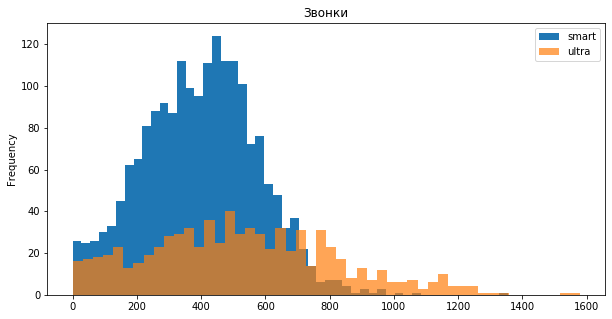

In [93]:
data_analysis.query('tariff == "smart"')['calls_sum'].plot(kind = 'hist',bins = 50, label = 'smart', figsize = (10,5))
data_analysis.query('tariff == "ultra"')['calls_sum'].plot(kind = 'hist',bins = 50, alpha =0.7, label = 'ultra', 
                                                                                                figsize = (10,5))

plt.title('Звонки')
plt.legend()
plt.show()

Посмоотрим на вид распеределения

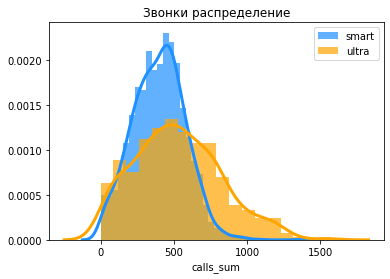

In [97]:
sns.distplot(data_analysis.query('tariff == "smart"')['calls_sum'], 
             color="dodgerblue", 
             label='smart', 
             hist_kws={'alpha':.7}, 
             kde_kws={'linewidth':3})

sns.distplot(data_analysis.query('tariff == "ultra"')['calls_sum'], 
             color="orange", 
             label="ultra", 
             hist_kws={'alpha':.7}, 
             kde_kws={'linewidth':3})

plt.title('Звонки распределение')
plt.legend()
plt.show()

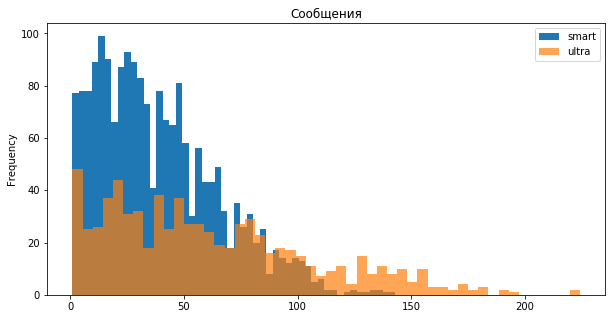

In [82]:
data_analysis.query('tariff == "smart"')['mes_count'].plot(kind = 'hist',bins = 50, label = 'smart', figsize = (10,5))
data_analysis.query('tariff == "ultra"')['mes_count'].plot(kind = 'hist',bins = 50, alpha =0.7, label = 'ultra', 
                                                                                                figsize = (10,5))

plt.title('Сообщения')
plt.legend()
plt.show()

Посмоотрим на вид распеределения

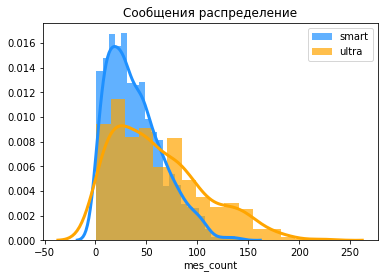

In [96]:
sns.distplot(data_analysis.query('tariff == "smart"')['mes_count'], 
             color="dodgerblue", 
             label='smart', 
             hist_kws={'alpha':.7}, 
             kde_kws={'linewidth':3})

sns.distplot(data_analysis.query('tariff == "ultra"')['mes_count'], 
             color="orange", 
             label="ultra", 
             hist_kws={'alpha':.7}, 
             kde_kws={'linewidth':3})

plt.title('Сообщения распределение')
plt.legend()
plt.show()

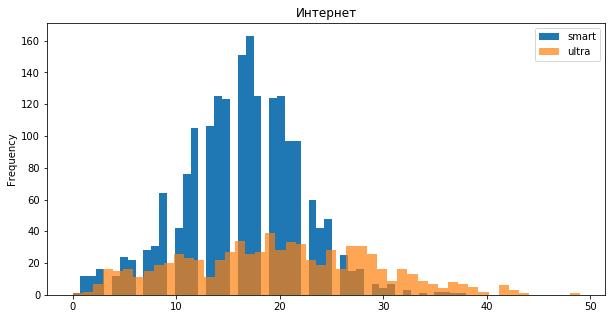

In [77]:
data_analysis.query('tariff == "smart"')['int_sum_gb'].plot(kind = 'hist',bins = 50, label = 'smart', figsize = (10,5))
data_analysis.query('tariff == "ultra"')['int_sum_gb'].plot(kind = 'hist',bins = 50, alpha =0.7, label = 'ultra', 
                                                                                                figsize = (10,5))

plt.title('Интернет')
plt.legend()
plt.show()

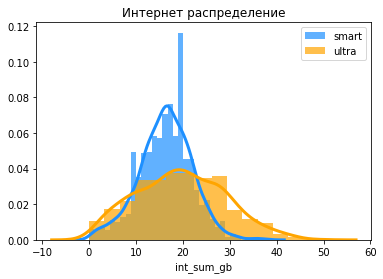

In [95]:
sns.distplot(data_analysis.query('tariff == "smart"')['int_sum_gb'], 
             color="dodgerblue", 
             label='smart', 
             hist_kws={'alpha':.7}, 
             kde_kws={'linewidth':3})

sns.distplot(data_analysis.query('tariff == "ultra"')['int_sum_gb'], 
             color="orange", 
             label="ultra", 
             hist_kws={'alpha':.7}, 
             kde_kws={'linewidth':3})

plt.title('Интернет распределение')
plt.legend()
plt.show()

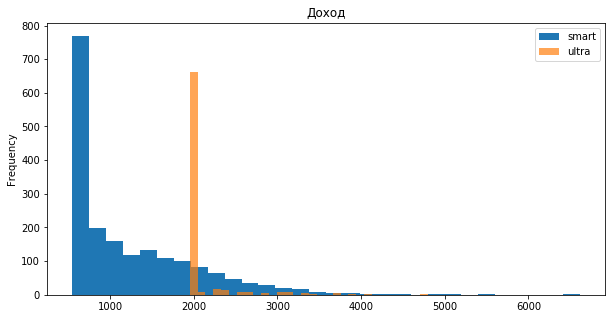

In [81]:
data_analysis.query('tariff == "smart"')['profit'].plot(kind = 'hist',bins = 30, label = 'smart', figsize = (10,5))
data_analysis.query('tariff == "ultra"')['profit'].plot(kind = 'hist',bins = 30, alpha =0.7, label = 'ultra', 
                                                                                                figsize = (10,5))

plt.title('Доход')
plt.legend()
plt.show()

На доходе уже распределение не посмотрим, т.к. есть очень сильно выбивающиеся значанеия: те, кто платит тольок абонентскую плату. И поэтомуу distplot построится не очень красиво.

Вывод: На гистограммах видно,у тарифа "ультра" гистограммы скошены немного вправо, у "смарт" скошены немного влево. Это видно и по медианам и средним, которые делали в таблицах выше, а также по графикам распределения. Пользователи тарифа "ультра" не тратят весь базовый пакет минут и количества смс, в отличие от тарифа "смарт" - это может пригодиться для рекланого отдела, чтобы делать более эффективные маркетинговые сообщения.

## Шаг 4. Проверяем гипотезы

<b/>Первая гипотеза<b/> 

Нулевая гипотеза: средняя выручка пользователей тарифов «Ультра» и «Смарт» равны

Альтернативная гипотеза : средняя выручка пользователей тарифов «Ультра» и «Смарт» различается

Проверим нулевую гипотезу

Будем использовать двухсторонний t-тест и сравнивать с альфой - в 5 %.

In [61]:
alpha = 0.05

profit_smart = data_analysis.query('tariff == "smart"')['profit']
profit_ultra = data_analysis.query('tariff == "ultra"')['profit']

result = st.ttest_ind(profit_smart,profit_ultra, equal_var=False) #который не предполагает равную дисперсию совокупности

prob = result.pvalue
print("p-значение:", prob)
if prob < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не отвергаем нулевую гипотезу") 

p-значение: 7.81690869801331e-233
Отвергаем нулевую гипотезу


In [62]:
print('Дисперсия первой совокупности:',np.var(profit_smart))
print('Дисперсия второй совокупности:',np.var(profit_ultra))

Дисперсия первой совокупности: 648837.90701525
Дисперсия второй совокупности: 110670.41081937529


Вывод: альфа больше р-значения, значит следует, что средние значение выручки разных тарифов не равно, поэтому принимаем альтернативную гипотезу.

<b/>Вторая гипотеза<b/> 

Нулевая гипотеза: средняя выручка пользователей из Москвы <b>не отличается</b> от выручки пользователей из других регионов.

Альтернативная гипотеза : средняя выручка пользователей из Москвы <b>отличается</b> от выручки пользователей из других регионов.

Проверим нулевую гипотезу

Будем использовать двухсторонний t-тест и сравнивать с альфой - в 5 %.


In [63]:
alpha = 0.05

city_moscow = data_analysis.query('city == "Москва"')['profit']
city_other = data_analysis.query('city != "Москва"')['profit']

result_city = st.ttest_ind(city_moscow,city_other, equal_var=False) #который не предполагает равную дисперсию совокупности

prob_city = result_city.pvalue
print("p-значение:", prob_city)
if prob_city < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не отвергаем нулевую гипотезу")
    

p-значение: 0.0738202477776709
Не отвергаем нулевую гипотезу


In [64]:
print('Дисперсия первой совокупности:',np.var(city_moscow))
print('Дисперсия второй совокупности:',np.var(city_other))

Дисперсия первой совокупности: 587650.9680729713
Дисперсия второй совокупности: 633261.4588337935


Вывод: средняя выручка пользователей из Москвы не отличается от средней выручки из других городов

## Шаг 5 Общий вывод

Мы провели предварительный анализ данных на небольшой выборке - 500 человек. Но уже по ней можно сделать главный ввод, который задал коммерческий депортамент:
тариф ультра приносит на одного пользователя 1950 р/месяц, а "смарт" только 950 р/мес. Это по медианным значениям. Моэтому стоит скорректировать рекламные бюджеты в сторону тарифа "ультра".

По моему мнению, в дальнейшем, чтобы строить рекламную стратегию нужно изучить пол/возрастные категории и делать стратифицировнные выборки, чтобы максимально эффективно использовать рекламные возможности, как таргетированная реклама. Но это вопрос уже другого проекта.

Также в этом прокте мы проверили 2 гипотизы используя двухсторонний t-тест с альфой - в 5 %: 
1ая гипотиза, что средняя выручка пользователей тарифов «Ультра» и «Смарт» равны - её мы отвергли,
2ая гипотиза, что средняя выручка пользователей из Москвы не отличается от средней выручки из других городов - не отвергли, тоесть вывод верный.